In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
data_dir = '/content/drive/MyDrive/CVPR/tumor_cs'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_and_masks(base_dir, target_size=(128, 128)):
    images = []
    masks = []

    # Loop through each folder in the base directory
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)

        if os.path.isdir(folder_path):
            print(f"Processing folder: {folder}")  # Debugging line

            image_files = []
            mask_files = []

            # Loop through each file in the folder
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)

                if filename.endswith(('.jpg', '.png', '.jpeg', '.tif')) and "_mask.tif" not in filename:
                    image_files.append(filename)  # Save image filenames
                if filename.endswith("_mask.tif"):
                    mask_files.append(filename)  # Save mask filenames

            # Extract image numbers and sort them
            image_numbers = [int(f.split('_')[-1].split('.')[0]) for f in image_files]
            mask_numbers = [int(f.split('_')[-2].split('.')[0]) for f in mask_files]

            # Sort based on the numbers
            image_files_sorted = [x for _, x in sorted(zip(image_numbers, image_files))]
            mask_files_sorted = [x for _, x in sorted(zip(mask_numbers, mask_files))]

            # Loop through image and mask files and load them
            for img_file, mask_file in zip(image_files_sorted, mask_files_sorted):
                img_path = os.path.join(folder_path, img_file)
                mask_path = os.path.join(folder_path, mask_file)

                try:
                    print(f"Loading image: {img_path}")  # Debugging line
                    img = load_img(img_path, target_size=target_size, color_mode='rgb')
                    img = img_to_array(img)
                    images.append(img)

                    print(f"Loading mask: {mask_path}")  # Debugging line
                    mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')
                    mask = img_to_array(mask) / 255.0  # Normalize mask to [0, 1]
                    masks.append(mask)
                except Exception as e:
                    print(f"Error loading image/mask pair {img_path}, {mask_path}: {e}")

    return np.array(images), np.array(masks)

# Example usage:
data_dir = '/content/drive/MyDrive/CVPR/Tumor_CS'  # আপনার ডিরেক্টরি
train_images, train_masks = load_images_and_masks(data_dir)

# Checking the number of images and masks loaded
print(f"Number of training images: {len(train_images)}")
print(f"Number of training masks: {len(train_masks)}")

# Checking the shape of the first image and mask
print(f"First image shape: {train_images[0].shape}")
print(f"First mask shape: {train_masks[0].shape}")

# Reshaping masks to (samples, 128, 128, 1)
train_masks = train_masks.reshape(-1, 128, 128, 1)
print(f"Final mask shape: {train_masks.shape}")


Processing folder: TCGA_CS_4941_19960909
Loading image: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
Loading mask: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif
Loading image: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_2.tif
Loading mask: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_2_mask.tif
Loading image: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_3.tif
Loading mask: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_3_mask.tif
Loading image: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_4.tif
Loading mask: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_4_mask.tif
Loading image: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_5.tif
Loading mask: /content/dr

In [ ]:
# #image loading
# import os
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# def load_images_from_folders(base_dir, target_size=(128, 128)):
#     images = []
#     labels = []

#     # Loop through each folder in the base directory (1st level of subfolders)
#     for folder in os.listdir(base_dir):
#         folder_path = os.path.join(base_dir, folder)

#         # Check if the path is a directory (subfolder)
#         if os.path.isdir(folder_path):
#             print(f"Processing folder: {folder}")  # Debugging line
#             # Loop through each image in the folder
#             for filename in os.listdir(folder_path):
#                 img_path = os.path.join(folder_path, filename)

#                 # Debugging line to check the files being processed
#                 #print(f"Checking file: {img_path}")

#                 # Ensure it's an image file (jpg/png/jpeg/tif) and doesn't have "_mask.tif" in the filename
#                 if (img_path.endswith(".jpg") or img_path.endswith(".png") or img_path.endswith(".jpeg") or img_path.endswith(".tif")):
#                     if "_mask.tif" not in filename:  # Check if the filename contains "_mask.tif"
#                         print(f"Loading image: {img_path}")  # Debugging line
#                         try:
#                             img = load_img(img_path, target_size=target_size, color_mode='rgb')
#                             img = img_to_array(img)
#                             images.append(img)

#                             # Label is the name of the folder
#                             labels.append(folder)
#                         except Exception as e:
#                             print(f"Error loading image {img_path}: {e}")

#     return np.array(images), np.array(labels)


# # Example usage:
# data_dir = '/content/drive/MyDrive/CVPR/Tumor_CS'
# train_images, train_labels = load_images_from_folders(data_dir)

# # Checking the number of images and labels loaded
# print(f"Number of training images: {len(train_images)}")
# print(f"Number of training labels: {len(train_labels)}")

# # Checking first few labels
# print(f"First few labels: {train_labels[:5]}")


In [ ]:
# #mask loading
# import os
# import numpy as np
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# def load_masks_from_folders(base_dir, target_size=(128, 128)):
#     masks = []

#     # Loop through each folder in the base directory
#     for folder in os.listdir(base_dir):
#         folder_path = os.path.join(base_dir, folder)

#         if os.path.isdir(folder_path):
#             print(f"Processing mask folder: {folder}")  # Debugging line

#             for filename in os.listdir(folder_path):
#                 if filename.endswith("_mask.tif"):  # ✅ শুধুমাত্র মাস্ক ফাইল লোড করবো
#                     mask_path = os.path.join(folder_path, filename)
#                     print(f"Loading mask: {mask_path}")  # Debugging line

#                     try:
#                         # Load mask in grayscale mode
#                         mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')
#                         mask = img_to_array(mask) / 255.0  # Normalize to [0,1]
#                         masks.append(mask)
#                     except Exception as e:
#                         print(f"Error loading mask {mask_path}: {e}")

#     return np.array(masks)

# # Example usage:
# mask_dir = '/content/drive/MyDrive/CVPR/Tumor_CS'  # ✅ তোমার মূল ডিরেক্টরি (ইমেজ ও মাস্ক একই ফোল্ডারে)
# train_masks = load_masks_from_folders(mask_dir)

# # Checking the number of masks loaded
# print(f"Number of training masks: {len(train_masks)}")

# # Checking the shape of the first mask
# print(f"First mask shape: {train_masks[0].shape}")

# # Reshaping masks to (samples, 128, 128, 1)
# train_masks = train_masks.reshape(-1, 128, 128, 1)
# print(f"Final mask shape: {train_masks.shape}")


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Example: Assuming you've loaded your images and masks already
# Let's use the same function you used to load images and masks.
train_images, train_masks = load_images_and_masks('/content/drive/MyDrive/CVPR/Tumor_CS')

# Normalize the images
train_images = train_images / 255.0

# Encode labels based on folder names (if you are categorizing based on folders)
# Here, we assume the folder name corresponds to the label.
train_labels = np.array([folder for folder in os.listdir('/content/drive/MyDrive/CVPR/Tumor_CS') if os.path.isdir(os.path.join('/content/drive/MyDrive/CVPR/Tumor_CS', folder))])

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Reshape images to match the model input (assuming 128x128x3 for RGB images)
train_images = train_images.reshape(-1, 128, 128, 3)

# One-hot encode labels (if necessary)
train_labels_encoded = tf.keras.utils.to_categorical(train_labels_encoded)

# Now you can use train_images and train_labels_encoded for training


Processing folder: TCGA_CS_4941_19960909
Loading image: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
Loading mask: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif
Loading image: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_2.tif
Loading mask: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_2_mask.tif
Loading image: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_3.tif
Loading mask: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_3_mask.tif
Loading image: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_4.tif
Loading mask: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_4_mask.tif
Loading image: /content/drive/MyDrive/CVPR/Tumor_CS/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_5.tif
Loading mask: /content/dr

In [ ]:
# class AttentionBlock(layers.Layer):
#     def __init__(self, filters):
#         super(AttentionBlock, self).__init__()
#         self.filters = filters

#     def build(self, input_shape):
#         self.conv1 = layers.Conv2D(self.filters, (1, 1), activation='relu', padding='same')
#         self.conv2 = layers.Conv2D(self.filters, (1, 1), activation='sigmoid', padding='same')

#     def call(self, inputs):
#         query = self.conv1(inputs)
#         attention = self.conv2(query)
#         return inputs * attention


In [ ]:
class AttentionBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(self.filters, (1, 1), activation='relu', padding='same')
        self.conv2 = layers.Conv2D(self.filters, (1, 1), activation='sigmoid', padding='same')

    def call(self, inputs):
        query = self.conv1(inputs)
        attention = self.conv2(query)
        return inputs * attention


In [ ]:
def unet_with_attention(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Contracting path
    c1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bottleneck = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    bottleneck = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(bottleneck)

    # Expansive path with Attention Block
    u4 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    u4 = AttentionBlock(512)(u4)
    u4 = layers.Concatenate()([u4, c4])
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    u3 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c5)
    u3 = AttentionBlock(256)(u3)
    u3 = layers.Concatenate()([u3, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u2 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c6)
    u2 = AttentionBlock(128)(u2)
    u2 = layers.Concatenate()([u2, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u1 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u1 = AttentionBlock(128)(u1)
    u1 = layers.Concatenate()([u1, c1])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
# import matplotlib.pyplot as plt

# def display_images_with_masks(images, masks, num_samples=5):
#     """ Display `num_samples` images with their corresponding masks """
#     plt.figure(figsize=(10, num_samples * 3))

#     for i in range(num_samples):
#         # Original Image
#         plt.subplot(num_samples, 2, 2*i + 1)
#         plt.imshow(images[i].astype('uint8'))  # RGB Image
#         plt.title(f"Image {i+1}")
#         plt.axis("off")

#         # Corresponding Mask
#         plt.subplot(num_samples, 2, 2*i + 2)
#         plt.imshow(masks[i].squeeze(), cmap="gray")  # Grayscale Mask
#         plt.title(f"Mask {i+1}")
#         plt.axis("off")

#     plt.tight_layout()
#     plt.show()

# # Call the function to display images and masks
# display_images_with_masks(train_images, train_masks, num_samples=5)


In [ ]:
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_encoded, test_size=0.2, random_state=42)


In [ ]:
model = unet_with_attention(input_size=(128, 128, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
print(f"Total images: {len(train_images)}")
print(f"Total masks: {len(train_masks)}")


Total images: 63
Total masks: 63


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)


In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=4)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 183s 13s/step - accuracy: 0.8283 - loss: 0.6768 - val_accuracy: 0.9898 - val_loss: 0.5614
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 195s 13s/step - accuracy: 0.9934 - loss: 0.4214 - val_accuracy: 0.9898 - val_loss: 0.1893
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 153s 12s/step - accuracy: 0.9908 - loss: 0.1492 - val_accuracy: 0.9898 - val_loss: 0.1055
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 212s 13s/step - accuracy: 0.9929 - loss: 0.0601 - val_accuracy: 0.9898 - val_loss: 0.0697
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 191s 12s/step - accuracy: 0.9926 - loss: 0.0520 - val_accuracy: 0.9898 - val_loss: 0.0589
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 213s 13s/step - accuracy: 0.9917 - loss: 0.0514 - val_accuracy: 0.9898 - val_loss: 0.0560
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 192s 12s/step - accuracy: 0.9942 - loss: 0.0346 - val_accuracy: 0.9898 - val_loss: 0.0508
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 211s 13s/step - accuracy: 0.9933 - loss: 0.0385 - val_accuracy: 0.

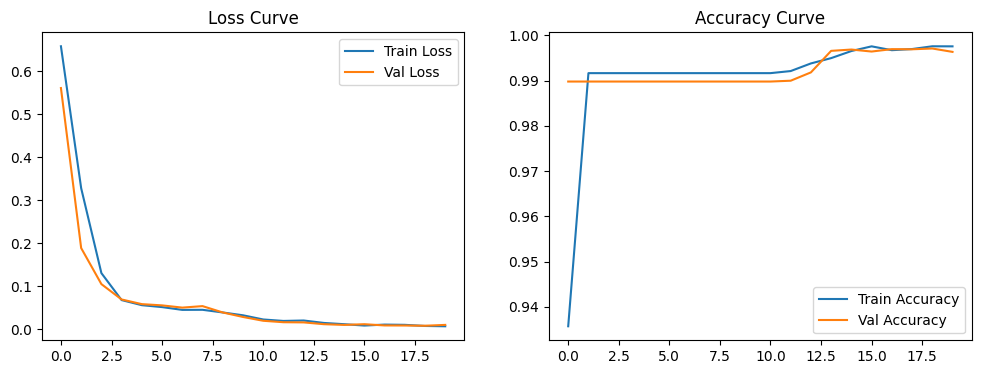

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [ ]:
loaded_model =model.save("/content/drive/MyDrive/CVPR/unet_attention_model.h5")



In [ ]:
from tensorflow.keras.models import load_model


custom_objects = {"AttentionBlock": AttentionBlock}


model_path = "/content/drive/MyDrive/CVPR/unet_attention_model.h5"

try:
    loaded_model = load_model(model_path, custom_objects=custom_objects)
    print("✅ মডেল সফলভাবে লোড হয়েছে!")
except Exception as e:
    print(f"❌ মডেল লোড করতে সমস্যা: {e}")


✅ মডেল সফলভাবে লোড হয়েছে!


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


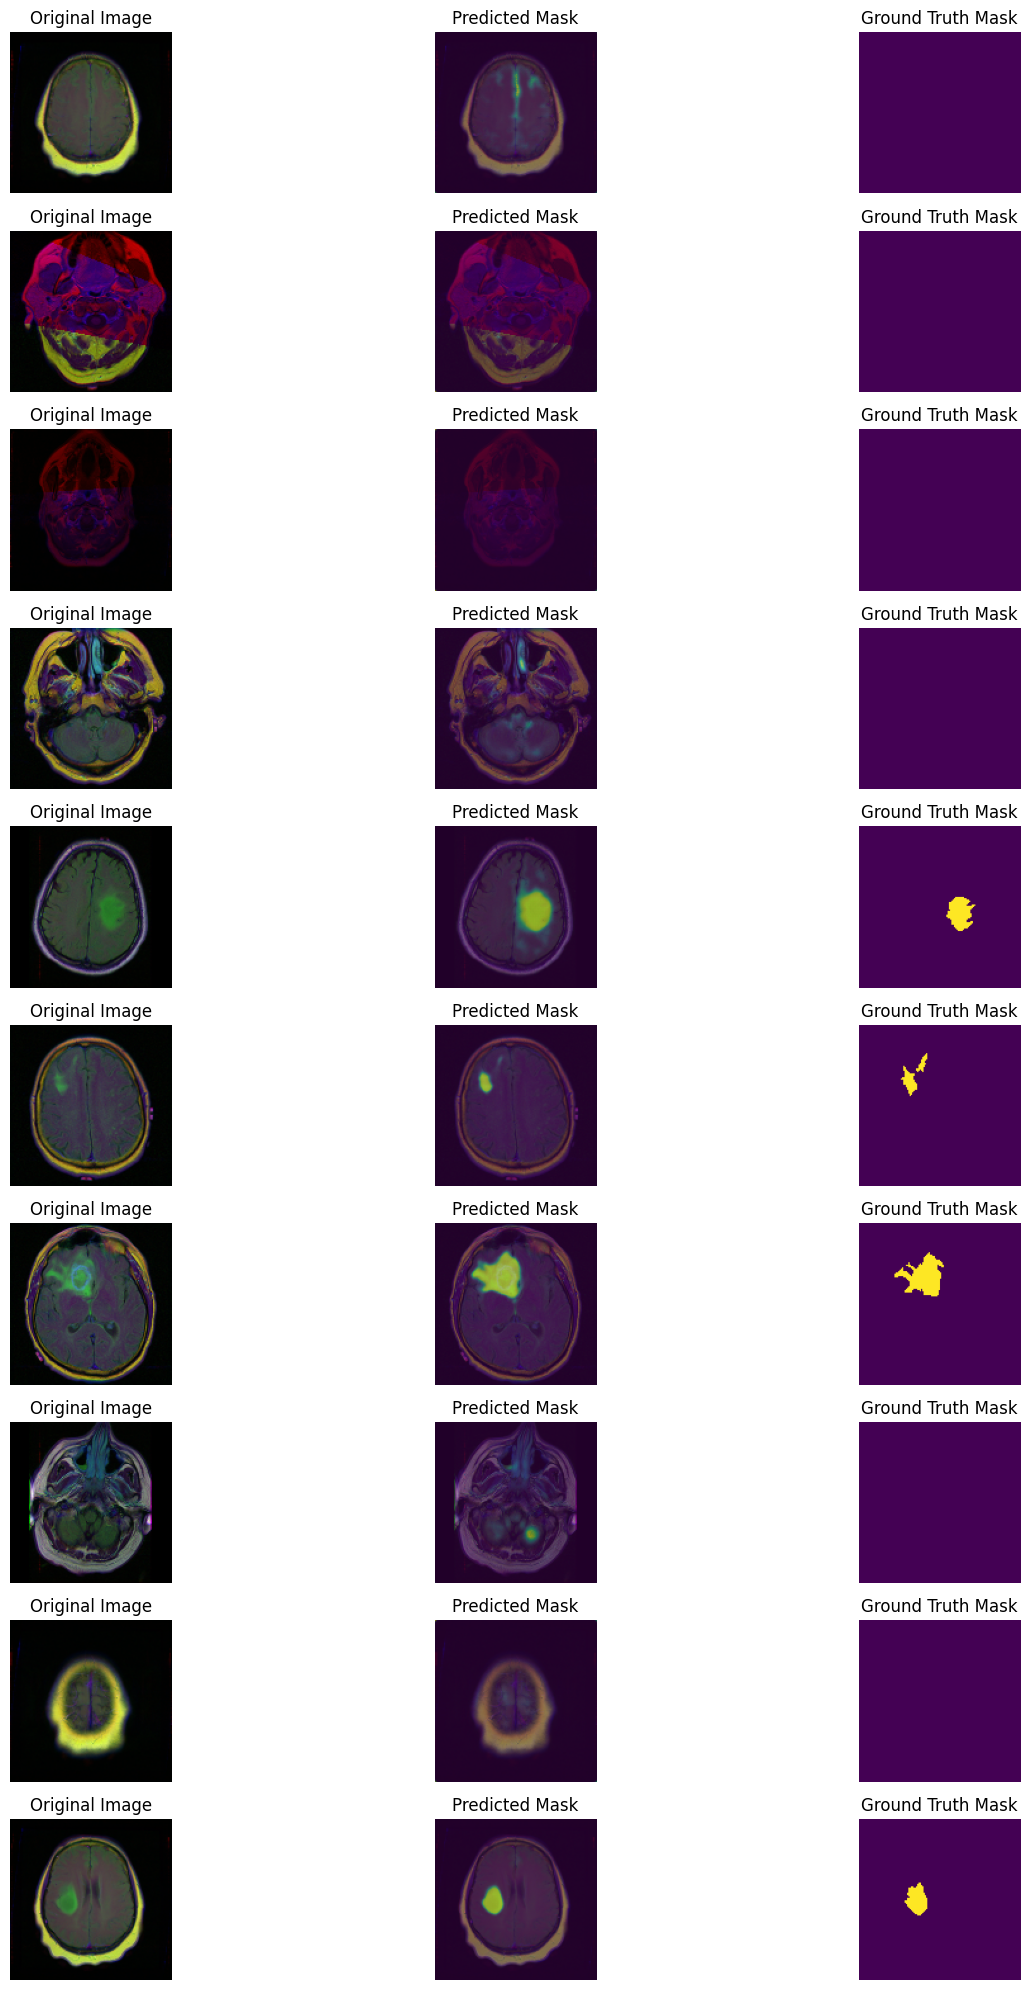

In [ ]:

mid_index = len(X_val) // 2
middle_test_images = X_val[mid_index - 5: mid_index + 5]
middle_ground_truth_masks = y_val[mid_index - 5: mid_index + 5]


predicted_masks = model.predict(middle_test_images)


plt.figure(figsize=(15, 20))

for i in range(10):
    plt.subplot(10, 3, 3*i + 1)
    plt.imshow(middle_test_images[i])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(10, 3, 3*i + 2)
    plt.imshow(middle_test_images[i])
    plt.imshow(predicted_masks[i].squeeze(), alpha=0.5)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(10, 3, 3*i + 3)
    plt.imshow(middle_ground_truth_masks[i].squeeze())
    plt.title("Ground Truth Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

test_loss, test_accuracy = model.evaluate(X_val, y_val, batch_size=8)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.9959 - loss: 0.0114
Test Loss: 0.01059508416801691
Test Accuracy: 0.996351957321167
